[![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/generation/aws/sagemaker/sagemaker-pinecone-rag.ipynb)

# Module 05 - Data Query


This module contains notebook code to:
* Query the data from Pinecone Index
* Perform semantic search
* Generate RAG response using Amazon Bedrock 


*******************************************************************************************************************

### Install required libraries

In [ ]:
pip install pinecone-client ipywidgets boto3

To begin, we will initialize Amazon Bedrock and Pinecone that we'll need to use throughout the walkthrough.

In [ ]:
import json
import boto3
import botocore
from botocore.config import Config
import time
from pinecone import ServerlessSpec
from pinecone import Pinecone

### Initialize Pinecone

In [ ]:
pinecone_api_key = '<PINECONE_API_KEY>' #Provide Pinecone API key

In [ ]:
index_name = 'pinecone-bedrock-rag-demo'
namespace = 'pinecone-bedrock'

In [ ]:
pc = Pinecone(api_key=pinecone_api_key)
#spec = ServerlessSpec(cloud='aws', region='us-west-2')

### Initialize Bedrock

#### Use the instruction provided in the link to add Amazon Bedrock permissions to the IAM role that will use this SageMaker notebook [Using SageMaker Notebooks](https://docs.aws.amazon.com/bedrock/latest/userguide/api-setup.html#api-using-sage).

In [ ]:
config = Config(connect_timeout=5, read_timeout=60, retries={"total_max_attempts": 20, "mode": "adaptive"})
region = 'us-east-1'

bedrock = boto3.client(
                service_name='bedrock-runtime',
                region_name=region,
                aws_access_key_id='', #Provide AWS Access Key
                aws_secret_access_key='', #Provide AWS Secret Access Key
                aws_session_token='', #Provide AWS Session Token
                endpoint_url=f'https://bedrock-runtime.{region}.amazonaws.com',
                                    config=config)

In [ ]:
def titan_text_embeddings(docs: str) -> list[float]:
    body = json.dumps({
        "inputText": docs,
    })
    
    model_id = 'amazon.titan-embed-text-v1'
    accept = 'application/json' 
    content_type = 'application/json'
    
    # Invoke model 
    response = bedrock.invoke_model(
        body=body, 
        modelId=model_id, 
        accept=accept, 
        contentType=content_type
    )
    
    # Parse response
    response_body = json.loads(response['body'].read())
    embedding = response_body.get('embedding')
    return embedding

In [ ]:
def model_args(query):
    query_model_args = {"prompt": query, "max_tokens_to_sample": 1000, "stop_sequences": [], "temperature": 0.0, "top_p": 0.9 }
    return query_model_args

We are using Anthropic Claude V2 model as our Large Language Model (LLM) in Amazon Bedrock for this walkthrough 

In [ ]:
def invoke_bedrock(query):
    output = []
    try:
        body = json.dumps(model_args(query))
        modelId = 'anthropic.claude-v2:1'
        contentType = "application/json"
        accept = "*/*"
        response = bedrock.invoke_model_with_response_stream(body=body, modelId=modelId, accept=accept, contentType=contentType)
        stream = response.get('body')
        
        i = 1
        if stream:
            for event in stream:
                chunk = event.get('chunk')
                if chunk:
                    chunk_obj = json.loads(chunk.get('bytes').decode())
                    text = chunk_obj['completion']
                    output.append(text)
                    print(text,end='')
                    i+=1
                
    except botocore.exceptions.ClientError as error:
        
        if error.response['Error']['Code'] == 'AccessDeniedException':
            print(f"\x1b[41m{error.response['Error']['Message']}\
                    \nTo troubeshoot this issue please refer to the following resources.\
                    \nhttps://docs.aws.amazon.com/IAM/latest/UserGuide/troubleshoot_access-denied.html\
                    \nhttps://docs.aws.amazon.com/bedrock/latest/userguide/security-iam.html\x1b[0m\n")
            
        else:
            raise error

### Initialize Pinecone Index and describe stats

In [ ]:
index = pc.Index(index_name)

In [ ]:
print(index.describe_index_stats())

### Query the data

Now we're ready begin querying our LLM with a **R**etrieval **A**ugmented **G**eneration (RAG) pipeline. Let's see how this will work step-by-step first.

#### Step 1. Generate vector embeddings of the text query 
#### Step 2. Perform Semantic Search and get relevant data to compose Context
#### Step 3. Invoke LLM with the Prompt, Context and Question

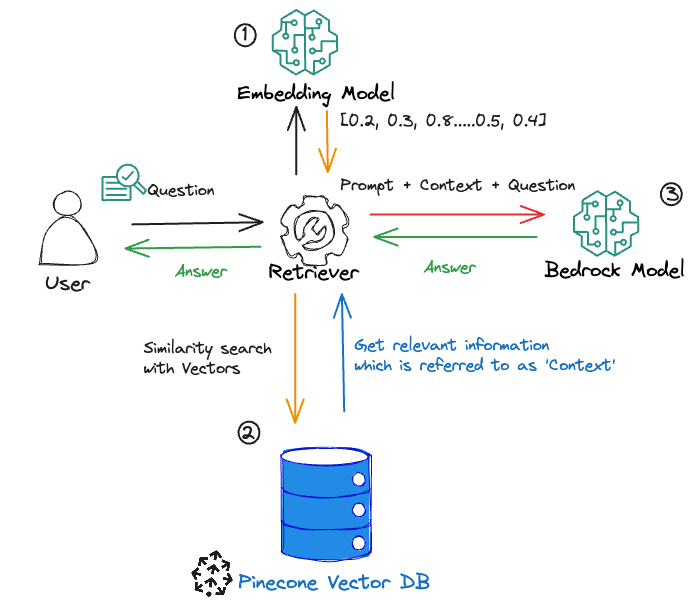

First we create our _query embedding_ and use it to query Pinecone:

### Step 1: Create vector embeddings for the query


#### For this workshop we loaded the data of Richard Feynman Lectures which are present in pdf documents format. There are 7 lectures on different topics in Physics. Feel free to ask any questions related to those topics. For exploring the content, look into the documents which are present in the data folder.

In [ ]:
question = 'Give me some quotes from Richard Feynman lectures on physics.'
print(question)

In [ ]:
# extract embeddings for the questions
query_vec = titan_text_embeddings(question)
print(query_vec)


In [ ]:
# query pinecone
res = index.query(vector=query_vec, top_k=10, namespace=namespace,include_metadata=True)

# show the results
res

### Step 2: Parse the Semantic Search results and contruct a single `context` to feed into our LLM prompt.

In [ ]:
contexts = [match.metadata["text"] for match in res.matches]

In [ ]:
max_section_len = 2000
separator = "\n"


def construct_context(contexts: list[str]) -> str:
    chosen_sections = []
    chosen_sections_len = 0

    for text in contexts:
        text = text.strip()
        # Add contexts until we run out of space.
        chosen_sections_len += len(text) + 2
        if chosen_sections_len > max_section_len:
            break
        chosen_sections.append(text)
    concatenated_doc = separator.join(chosen_sections)
    print(
        f"With maximum sequence length {max_section_len}, selected top {len(chosen_sections)} document sections: \n{concatenated_doc}"
    )
    return concatenated_doc

In [ ]:
context_str = construct_context(contexts=contexts)

### Step 3: Invoke the LLM with the Prompt + Context + Question

In [ ]:
query = f"""Human: Answer the following QUESTION based on the CONTEXT
given. If you do not know the answer and the CONTEXT doesn't
contain the answer truthfully say "I don't know".

QUESTION:
{question}

CONTEXT:
{context_str}


Assistant:
"""
print("Query Prompt:", str(query))

In [ ]:
invoke_bedrock(query)

Now you can see the generated answer is factually accurate and how the RAG could provide real-time knowledge to the LLM and help reducing hallucination

In this module, we demonstrated the step-by-step process of querying data from Pinecone Index and use it to generate RAG response using Amazon Bedrock. 

---